In [1]:
import pandas as pd
import numpy as np

# import the packages needed to
# 1. Develop an xgboost or other gradient boosting model
# 2. Encode text data for use in the xgboost model
# 3. Evaluate the model including gini and ROC curve, variable importance, effective size
# 4. Tune the model

# import the packages
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import log_loss
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from xgboost import XGBClassifier
from xgboost import plot_importance
import matplotlib.pyplot as plt
import seaborn as sns
import pyarrow.parquet as pq
import polars as pl
import gc

filepath = "C:/Users/shane/Downloads/analyticsDF.parquet"

analyticsDF = pl.read_parquet(filepath)
colsToFix = {
    "loan_amount": "int64",
    "tract_population": "int64",
}

for col in colsToFix:
    analyticsDF = analyticsDF.with_columns([pl.col(col).cast(pl.Int64)])
colsToFill = {
    "loan_term": {-99: 360},
    
}
for col in colsToFill:
    analyticsDF = analyticsDF.with_columns([pl.col(col).replace(colsToFill[col])])
colsToImpute = [
    "interest_rate",
    "intro_rate_period",
    "prepayment_penalty_term",
    "discount_points",
    "total_points_and_fees",
    "multifamily_affordable_units",
    "total_loan_costs",
    "total_points_and_fees",
    "origination_charges",
    "discount_points",
    "lender_credits",
    "prepayment_penalty_term",
    "intro_rate_period",
]
for col in colsToImpute:
    analyticsDF = analyticsDF.with_columns([pl.col(col).replace(-99, np.nan)])
    meanVal = analyticsDF[col].mean()
    analyticsDF = analyticsDF.with_columns([pl.col(col).fill_null(meanVal)])
    
cols = analyticsDF.columns

countyDF = analyticsDF.select([
    "county_code", "activity_year", "census_tract", "tract_population", "tract_minority_population_percent",
    "tract_to_msa_income_percentage", "tract_owner_occupied_units", "tract_one_to_four_family_homes",
    "tract_median_age_of_housing_units"
])

# deduplicate on county_code, activity_year, census_tract to get the first instance of each
countyDF = countyDF.group_by(["county_code", "activity_year", "census_tract"]).first()

# calculate the weighted value of each of "tract_minority_population_percent",
    # "tract_to_msa_income_percentage", "tract_owner_occupied_units", "tract_one_to_four_family_homes",
    # "tract_median_age_of_housing_units"
countyDF = countyDF.with_columns(
    (pl.col("tract_population") * pl.col("tract_minority_population_percent")).alias("minority_population_weighted"),
    (pl.col("tract_population") * pl.col("tract_to_msa_income_percentage")).alias("income_weighted"),
    (pl.col("tract_population") * pl.col("tract_median_age_of_housing_units")).alias("median_age_weighted")
)

# group by county_code and activity_year, taking 
# the sum of tract_population, tract_owner_occupied_units, tract_one_to_four_family_homes
# the mean of minority_population_weighted, income_weighted, median_age_weighted

countyDF = countyDF.group_by(["county_code", "activity_year"]).agg([
    pl.sum("tract_population").alias("county_population"),
    pl.sum("minority_population_weighted").alias("minority_population_percent"),
    pl.sum("income_weighted").alias("avg_msa_income_percent"),
    pl.sum("tract_owner_occupied_units").alias("county_owner_occupied_units"),
    pl.sum("tract_one_to_four_family_homes").alias("county_one_to_four_family_homes"),
    pl.sum("median_age_weighted").alias("county_avg_housing_age")
])

# convert weighted values back to percentages
countyDF = countyDF.with_columns(
    (pl.col("minority_population_percent") / pl.col("county_population")).alias("minority_population_percent"),
    (pl.col("avg_msa_income_percent") / pl.col("county_population")).alias("avg_msa_income_percent"),
    (pl.col("county_avg_housing_age") / pl.col("county_population")).alias("county_avg_housing_age")
)

# merge the countyDF back on
analyticsDF = analyticsDF.join(
    countyDF, on=["county_code", "activity_year"], how="left"
)

descriptiveCols = [
    "activity_year",
    "lei",
    "derived_msa_md",
    "census_tract",
]

countyColsToAgg = [
    "tract_population", "tract_minority_population_percent", "tract_to_msa_income_percentage",
    "tract_owner_occupied_units", "tract_one_to_four_family_homes", "tract_median_age_of_housing_units",
    
]

colsToDrop = [
    "loan_purpose", "reverse_mortgage", "open_end_line_of_credit", "tract_population", "tract_minority_population_percent", "tract_to_msa_income_percentage",
    "tract_owner_occupied_units", "tract_one_to_four_family_homes", "tract_median_age_of_housing_units", "denial_reasons"
]

categoryCols = [
    "state_code", "county_code", "conforming_loan_limit", "derived_loan_product_type",
    "derived_dwelling_category", "derived_ethnicity", "derived_race", "derived_sex",
    "action_taken", "purchaser_type", "loan_type", "loan_purpose", "lien_status",
    "hoepa_status", "construction_method", "occupancy_type", "debt_to_income_ratio",
    "applicant_credit_score_type", "co_applicant_credit_score_type", "applicant_age",
    "co_applicant_age", "co_applicant_age_above_62", "applicant_age_above_62", "aus_1",
    "aus_2", "aus_3", "aus_4", "aus_5", "applicant_ethnicitys", "co_applicant_ethnicitys",
    "applicant_races", "co_applicant_races",  "total_units"
]    

numCols = [
    "loan_amount", "combined_loan_to_value_ratio", "interest_rate", "rate_spread",
    "total_loan_costs", "total_points_and_fees", "origination_charges", "discount_points",
    "lender_credits", "loan_term", "prepayment_penalty_term", "intro_rate_period",
    "property_value", "multifamily_affordable_units", "income", "total_units_val",
    "debt_to_income_ratio_val", 
]

boolCols = [
    "preapproval", "business_or_commercial_purpose", "negative_amortization", "interest_only_payment",
    "balloon_payment", "other_nonamortizing_features",
]

# now let's build the model

# I don't want to include descriptiveCols as predictors, but I want them to remain in the model for reference
# drop cols from the analyticsDF in colsToDrop and then merge back on the cols from countyDF on county and activity year
# encode categoryCols and boolCols

# then build the model

# first drop the columns
analyticsDFFinal = analyticsDF.drop(colsToDrop)

# filter for values in action_taken that are not 4 or 5
# recode action_taken

actionTakenRecode = {
    "1": 1,
    "2": 1,
    "3": 0,
    "6": 1,
    "7": 0,
    "8": 1
}

analyticsDFFinal = analyticsDFFinal.filter(pl.col("action_taken")!="4").filter(pl.col("action_taken")!="5").with_columns([
    pl.col("action_taken").replace(actionTakenRecode).alias("action_taken")
])

valsToSplitAndExplode = [
    'applicant_ethnicitys',
    'co_applicant_ethnicitys',
    'applicant_races',
    'co_applicant_races',
]

print("Initial shape:", analyticsDFFinal.shape)

for col in valsToSplitAndExplode:
    # Corrected approach: Use str.split for splitting on "|"
    analyticsDFFinal = analyticsDFFinal.with_columns([
        pl.col(col).str.split("|").alias(col)
    ]).explode(col)
    
    print(f"After exploding {col}:", analyticsDFFinal.shape)

# now for col in valsToSplitAndExplode, fill "" with "Missing"

for col in valsToSplitAndExplode:
    analyticsDFFinal = analyticsDFFinal.with_columns([
        pl.col(col).replace("", "Missing")
    ])

print("Final shape:", analyticsDFFinal.shape)

for col in valsToSplitAndExplode:
    analyticsDFFinal = analyticsDFFinal.with_columns([
        pl.col(col).replace("", "None")
    ])

encodedLabels = {}

# encode the category columns
for col in categoryCols:
    print(col)
    if col not in analyticsDFFinal.columns:
        print("not in columns")
        continue
    le = LabelEncoder()
    transformation = le.fit_transform(analyticsDFFinal[col])
    analyticsDFFinal = analyticsDFFinal.drop(col).with_columns([
        pl.Series(transformation).alias(col)
    ])
    encodedLabels[col] = le

# encode the bool columns
for col in boolCols:
    print(col)
    if col not in analyticsDFFinal.columns:
        print("not in columns")
        continue
    analyticsDFFinal = analyticsDFFinal.with_columns([
        pl.col(col).cast(pl.Int64).alias(col)
    ])

# now let's scale the numeric columns

for col in numCols:
    print(col)
    if col not in analyticsDFFinal.columns:
        print("not in columns")
        continue
    meanVal = analyticsDFFinal[col].mean()
    stdVal = analyticsDFFinal[col].std()
    analyticsDFFinal = analyticsDFFinal.with_columns([
        ((pl.col(col) - meanVal) / stdVal).alias(col)
    ])

# split the data into predictors and target
sampleDF = analyticsDFFinal.sample(fraction=0.3)# .to_pandas()



Initial shape: (8211413, 66)
After exploding applicant_ethnicitys: (8235629, 66)
After exploding co_applicant_ethnicitys: (8246172, 66)
After exploding applicant_races: (8362424, 66)
After exploding co_applicant_races: (8431090, 66)
Final shape: (8431090, 66)
state_code
county_code
conforming_loan_limit
derived_loan_product_type
derived_dwelling_category
derived_ethnicity
derived_race
derived_sex
action_taken
purchaser_type
loan_type
loan_purpose
not in columns
lien_status
hoepa_status
construction_method
occupancy_type
debt_to_income_ratio
applicant_credit_score_type
co_applicant_credit_score_type
applicant_age
co_applicant_age
co_applicant_age_above_62
applicant_age_above_62
aus_1
aus_2
aus_3
aus_4
aus_5
applicant_ethnicitys
co_applicant_ethnicitys
applicant_races
co_applicant_races
total_units
preapproval
business_or_commercial_purpose
negative_amortization
interest_only_payment
balloon_payment
other_nonamortizing_features
loan_amount
combined_loan_to_value_ratio
interest_rate
rate_

AttributeError: 'DataFrame' object has no attribute 'to_parquet'

In [5]:
# convert a polars dataframe to parquet table, then write the table to a parquet file

sampleDF.write_parquet("C:/Users/shane/Downloads/sampleDF.parquet")
analyticsDFFinal.write_parquet("C:/Users/shane/Downloads/analyticsDFFinal.parquet")

In [49]:

trainDF, testDF = train_test_split(
    sampleDF,
    test_size=0.3,
    shuffle=True,
    random_state=4282,
    stratify=sampleDF["action_taken"]
)


In [25]:
# select rows from analytics df where county_code == 48029 and activity_year == 2020, selecting columns [
#     "county_code", "activity_year", "census_tract", "tract_population", "tract_minority_population_percent",
#     "tract_to_msa_income_percentage", "tract_owner_occupied_units", "tract_one_to_four_family_homes",
#     "tract_median_age_of_housing_units"
# ]

# then export the values to a csv file
countyCheck = analyticsDF.filter(pl.col("county_code") == "48029").filter(pl.col("activity_year") == "2020").select([
    "county_code", "activity_year", "census_tract", "tract_population", "tract_minority_population_percent",
    "tract_to_msa_income_percentage", "tract_owner_occupied_units", "tract_one_to_four_family_homes",
    "tract_median_age_of_housing_units"
])
# select the first of each tract in the county
countyCheck = countyCheck.groupby(["county_code", "activity_year", "census_tract"]).first()
countyCheck.write_csv("countyCheck.csv")

<ipython-input-25-eff6320ce6d8>:14: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  countyCheck = countyCheck.groupby(["county_code", "activity_year", "census_tract"]).first()


In [26]:
# here, let's check for collinearity - note I have a combination of variable types, but categorical variables have been encoded
# so I can use the Pearson correlation coefficient
%matplotlib notebook
import seaborn as sns
import matplotlib.pyplot as plt

corrMatrix = trainDF.to_pandas().corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()


<IPython.core.display.Javascript object>

In [50]:

# split the data into predictors and target
trainPredictors = trainDF.drop("action_taken")
trainPredictors = trainPredictors.drop(descriptiveCols).to_pandas()
trainTarget = trainDF["action_taken"].to_pandas()

testPredictors = testDF.drop("action_taken")
testPredictors = testPredictors.drop(descriptiveCols).to_pandas()
testTarget = testDF["action_taken"].to_pandas()

bestParams = {
    'colsample_bytree': 0.5,
    'learning_rate': 0.01,
    'max_depth': 7,
    'n_estimators': 1000,
    'subsample': 1.0
}

# build the model
model = XGBClassifier(
    n_estimators=bestParams["n_estimators"],
    max_depth=bestParams["max_depth"],
    learning_rate=bestParams["learning_rate"],
    subsample=bestParams["subsample"],
    colsample_bytree=bestParams["colsample_bytree"],
    objective="binary:logistic",
    eval_metric="logloss",
    use_label_encoder=True
)

In [ ]:

# fit the model
model.fit(trainPredictors, trainTarget)

# make predictions
trainPredictions = model.predict(trainPredictors.to_numpy())
testPredictions = model.predict(testPredictors.to_numpy())

# calculate the accuracy
trainAccuracy = accuracy_score(trainTarget.to_numpy(), trainPredictions)
testAccuracy = accuracy_score(testTarget.to_numpy(), testPredictions)

# calculate the precision
trainPrecision = precision_score(trainTarget.to_numpy(), trainPredictions)
testPrecision = precision_score(testTarget.to_numpy(), testPredictions)

# calculate the recall
trainRecall = recall_score(trainTarget.to_numpy(), trainPredictions)
testRecall = recall_score(testTarget.to_numpy(), testPredictions)

# calculate the f1 score
trainF1 = f1_score(trainTarget.to_numpy(), trainPredictions)
testF1 = f1_score(testTarget.to_numpy(), testPredictions)

# calculate the log loss
trainLogLoss = log_loss(trainTarget.to_numpy(), model.predict_proba(trainPredictors.to_numpy()))
testLogLoss = log_loss(testTarget.to_numpy(), model.predict_proba(testPredictors.to_numpy()))

# calculate the roc auc
trainROCAUC = roc_auc_score(trainTarget.to_numpy(), model.predict_proba(trainPredictors.to_numpy())[:,1])
testROCAUC = roc_auc_score(testTarget.to_numpy(), model.predict_proba(testPredictors.to_numpy())[:,1])

# calculate the confusion matrix
trainConfusionMatrix = confusion_matrix(trainTarget.to_numpy(), trainPredictions)
testConfusionMatrix = confusion_matrix(testTarget.to_numpy(), testPredictions)

# calculate the classification report
trainClassificationReport = classification_report(trainTarget.to_numpy(), trainPredictions)
testClassificationReport = classification_report(testTarget.to_numpy(), testPredictions)

# show importance


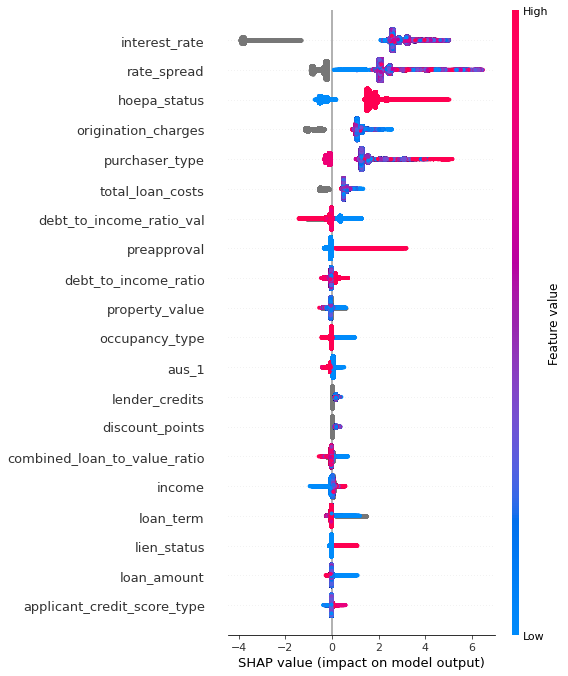

In [10]:
# now use shap on my model to show both feature importance AND the direction that each feature's values impact the model

import shap

# create a shap explainer
explainer = shap.Explainer(model)

# calculate the shap values
shap_values = explainer.shap_values(trainPredictors)

# plot the shap values
shap.summary_plot(shap_values, trainPredictors)

In [51]:
# create a parameter grid
paramGrid = {
    "max_depth": [3, 5, 7],
    "n_estimators": [100, 300, 500, 700, 1000],
    "learning_rate": [0.01, 0.05, 0.1, 0.3],
    "subsample": [0.3, 0.5, 0.8, 1.0],
    "colsample_bytree": [0.3, 0.5, 0.8, 1.0],
}

# create the grid search
gridSearch = GridSearchCV(
    estimator=model,
    param_grid=paramGrid,
    scoring="roc_auc",
    n_jobs=-1,  # use all available cores
    cv=2,  # 2-fold cross-validation
    verbose=3
)

# fit the grid search on the training data
gridSearch.fit(trainPredictors.to_numpy(), trainTarget.to_numpy())

# get the best parameters
bestParams = gridSearch.best_params_

# print the best parameters
print(f"Best parameters: {bestParams}")

# fit the model with the best parameters on the training data
model.set_params(**bestParams)
model.fit(trainPredictors.to_numpy(), trainTarget.to_numpy())

# make predictions on the test data
testPredictions = model.predict(testPredictors.to_numpy())

# calculate the accuracy on the test data
testAccuracy = accuracy_score(testTarget.to_numpy(), testPredictions)

# print the test accuracy
print(f"Test accuracy: {testAccuracy}")

Fitting 2 folds for each of 960 candidates, totalling 1920 fits


In [60]:
# now show all my results
print("Train Accuracy: ", trainAccuracy)
print("Test Accuracy: ", testAccuracy)

print("Train Precision: ", trainPrecision)
print("Test Precision: ", testPrecision)

print("Train Recall: ", trainRecall)
print("Test Recall: ", testRecall)

print("Train F1: ", trainF1)
print("Test F1: ", testF1)

print("Train Log Loss: ", trainLogLoss)
print("Test Log Loss: ", testLogLoss)

print("Train ROC AUC: ", trainROCAUC)
print("Test ROC AUC: ", testROCAUC)

print("Train Confusion Matrix: ", trainConfusionMatrix)
print("Test Confusion Matrix: ", testConfusionMatrix)

print("Train Classification Report: ", trainClassificationReport)
print("Test Classification Report: ", testClassificationReport)



Train Accuracy:  0.9994113881034287
Test Accuracy:  0.998272052306614
Train Precision:  0.9996770904693445
Test Precision:  0.999187100593672
Train Recall:  0.9996700170973597
Test Recall:  0.9988944201263605
Train F1:  0.9996735537708399
Test F1:  0.99904073892399
Train Log Loss:  0.0020134246666374165
Test Log Loss:  0.0046332295814021
Train ROC AUC:  0.9999950587157477
Test ROC AUC:  0.9999512365416985
Train Confusion Matrix:  [[ 169268     502]
 [    513 1554113]]
Test Confusion Matrix:  [[ 72772    541]
 [   736 664978]]
Train Classification Report:                precision    recall  f1-score   support

           0       1.00      1.00      1.00    169770
           1       1.00      1.00      1.00   1554626

    accuracy                           1.00   1724396
   macro avg       1.00      1.00      1.00   1724396
weighted avg       1.00      1.00      1.00   1724396

Test Classification Report:                precision    recall  f1-score   support

           0       0.99    

In [73]:


pd.DataFrame(
    trainConfusionMatrix,
    index=["Actual Negative", "Actual Positive"],
    columns=["Predicted Negative", "Predicted Positive"]
)

,Predicted Negative,Predicted Positive
Actual Negative,169268,502
Actual Positive,513,1554113


In [65]:
import tabulate as tab
trainClassificationReport = trainClassificationReport.split("\n")
tab.tabulate(trainClassificationReport, tablefmt="html")

,,,,,,,,,,,,,,p,r,e,c,i,s,i,o,n,,,,,r,e,c,a,l,l,,,f,1,-,s,c,o,r,e,,,,s,u,p,p,o,r,t
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,0,,,,,,,,1,.,0,0,,,,,,,1,.,0,0,,,,,,,1,.,0,0,,,,,1,6,9,7,7,0
,,,,,,,,,,,1,,,,,,,,1,.,0,0,,,,,,,1,.,0,0,,,,,,,1,.,0,0,,,,1,5,5,4,6,2,6
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,,,,a,c,c,u,r,a,c,y,,,,,,,,,,,,,,,,,,,,,,,,,,,,1,.,0,0,,,,1,7,2,4,3,9,6
,,,m,a,c,r,o,,a,v,g,,,,,,,,1,.,0,0,,,,,,,1,.,0,0,,,,,,,1,.,0,0,,,,1,7,2,4,3,9,6
w,e,i,g,h,t,e,d,,a,v,g,,,,,,,,1,.,0,0,,,,,,,1,.,0,0,,,,,,,1,.,0,0,,,,1,7,2,4,3,9,6
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


In [71]:
pd.DataFrame(
    classification_report(
        trainTarget.to_numpy(),
        trainPredictions,
        output_dict=True,
        target_names=["Unsuccessful", "Successful"],
        # is there a way to increase the number of decimal places?
        digits=4    
    )
)

,Unsuccessful,Successful,accuracy,macro avg,weighted avg
precision,0.996978,9.996771e-01,0.999411,9.983278e-01,9.994114e-01
recall,0.997043,9.996700e-01,0.999411,9.983565e-01,9.994114e-01
f1-score,0.997011,9.996736e-01,0.999411,9.983422e-01,9.994114e-01
support,169770.000000,1.554626e+06,0.999411,1.724396e+06,1.724396e+06


In [75]:
plot_importance(
    model,
    importance_type="gini",
    max_num_features=25,
    title="Feature Importance by Weight",
    # get features from Fnumber
    xlabel="F Score"
    
)



XGBoostError: [18:48:46] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\gbm\gbtree.h:266: Unknown feature importance type, expected one of: {"weight", "total_gain", "total_cover", "gain", "cover"}, got: gini